In [1]:
import pandas as pd
import numpy as np

import warnings
import os

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import RepeatedKFold


import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.font_manager import FontProperties
from matplotlib.gridspec import GridSpec

import shap

In [2]:
# Importing the data
df = pd.read_csv("data/df_shadow_econ.csv")

In [4]:
df['Log. GDP Per Capita'] = np.log(df['gdp_pc'])
df = df.drop('gdp_pc', axis=1)

In [5]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=0)

In [6]:
# train set
X_train = train_set.drop('Shadow Economy', axis=1)
y_train = train_set['Shadow Economy']

scaler = MinMaxScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

In [7]:
# test set
X_test = test_set.drop('Shadow Economy', axis=1)
y_test = test_set['Shadow Economy']

X_test_scaled = scaler.transform(X_test)

# Elastic net

In [8]:
from sklearn.linear_model import ElasticNet

en_param_grid = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
              'l1_ratio': [0.25, 0.5, 0.75],
              'fit_intercept': [True, False],
              'max_iter': [1000, 2000, 3000],
              'tol': [1e-4, 1e-3, 1e-2]}

# Create a lasso model
en_model = ElasticNet(random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Perform Grid Search with cross-validation
en_grid_search = GridSearchCV(en_model, 
                                  en_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=kf,
                                  n_jobs=-1)

# Fitting the model
en_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", en_grid_search.best_params_)

# Get the best model
en_best_model = en_grid_search.best_estimator_

# Store fold scores for later calculations
all_fold_scores = []

# Print the mean and standard deviation of each fold in percentage
for i, (train_idx, test_idx) in enumerate(kf.split(X_train_scaled, y_train)):
    fold_scores = -en_grid_search.cv_results_['split{}_test_score'.format(i)]
    all_fold_scores.extend(fold_scores)  # Store fold scores for later calculations
    mean_fold_score = np.mean(fold_scores) * 100
    std_fold_score = np.std(fold_scores) * 100  

    print(f'Mean score for fold {i + 1}: {mean_fold_score:.2f}%, Standard Deviation: {std_fold_score:.2f}%')

# Calculate and print global mean and standard deviation
global_mean = np.mean(all_fold_scores) * 100
global_std = np.std(all_fold_scores) * 100
print(f'Global Mean: {global_mean:.2f}%, Global Standard Deviation: {global_std:.2f}%\n')# Predictions and evaluations on test set
y_test_pred = en_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'\nMean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')


Best Parameters:  {'alpha': 0.001, 'fit_intercept': True, 'l1_ratio': 0.75, 'max_iter': 1000, 'tol': 0.0001}
Mean score for fold 1: 40.92%, Standard Deviation: 16.67%
Mean score for fold 2: 36.96%, Standard Deviation: 15.70%
Mean score for fold 3: 33.72%, Standard Deviation: 16.77%
Mean score for fold 4: 39.46%, Standard Deviation: 15.85%
Mean score for fold 5: 38.96%, Standard Deviation: 15.77%
Global Mean: 38.00%, Global Standard Deviation: 16.35%


Mean Absolute Percentage Error (MAPE) on test set: 27.77% 



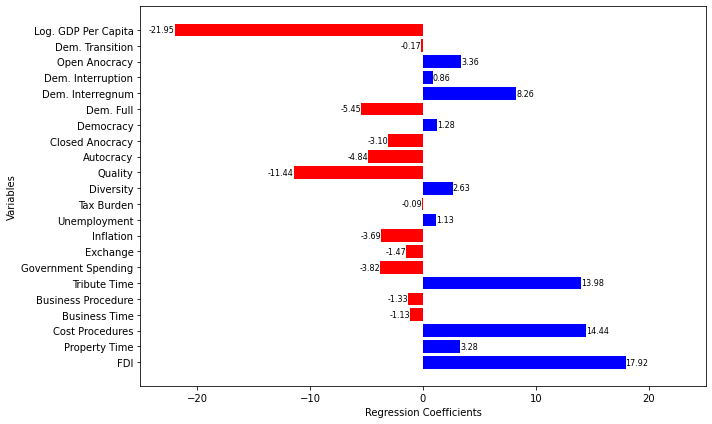

In [15]:
en_coeficients = en_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in en_coeficients]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, en_coeficients, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(en_coeficients):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()
ax = plt.gca()
ax.set_xlim(-25, 25)
        
plt.show()

# Linear regression

In [16]:
from sklearn.linear_model import LinearRegression

# Params set
linear_param_grid = {
    'fit_intercept': [True, False],
    'copy_X':[True, False]
}

# Create a linear regression model
linear_model = LinearRegression()

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Perform Grid Search with cross-validation
linear_grid_search = GridSearchCV(linear_model, 
                                  linear_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=kf,
                                  n_jobs=-1)

# Fitting the model
linear_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", linear_grid_search.best_params_)

# Get the best model
linear_best_model = linear_grid_search.best_estimator_

# Store fold scores for later calculations
all_fold_scores = []

# Print the mean and standard deviation of each fold in percentage
for i, (train_idx, test_idx) in enumerate(kf.split(X_train_scaled, y_train)):
    fold_scores = -linear_grid_search.cv_results_['split{}_test_score'.format(i)]
    all_fold_scores.extend(fold_scores)  # Store fold scores for later calculations
    mean_fold_score = np.mean(fold_scores) * 100
    std_fold_score = np.std(fold_scores) * 100  

    print(f'Mean score for fold {i + 1}: {mean_fold_score:.2f}%, Standard Deviation: {std_fold_score:.2f}%')

# Calculate and print global mean and standard deviation
global_mean = np.mean(all_fold_scores) * 100
global_std = np.std(all_fold_scores) * 100
print(f'Global Mean: {global_mean:.2f}%, Global Standard Deviation: {global_std:.2f}%\n')

# Predictions and evaluations on test set
y_test_pred = linear_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')


Best Parameters:  {'copy_X': True, 'fit_intercept': True}
Mean score for fold 1: 25.47%, Standard Deviation: 0.00%
Mean score for fold 2: 24.14%, Standard Deviation: 0.00%
Mean score for fold 3: 22.85%, Standard Deviation: 0.00%
Mean score for fold 4: 26.53%, Standard Deviation: 0.35%
Mean score for fold 5: 26.27%, Standard Deviation: 0.00%
Global Mean: 25.05%, Global Standard Deviation: 1.39%

Mean Absolute Percentage Error (MAPE) on test set: 27.77% 



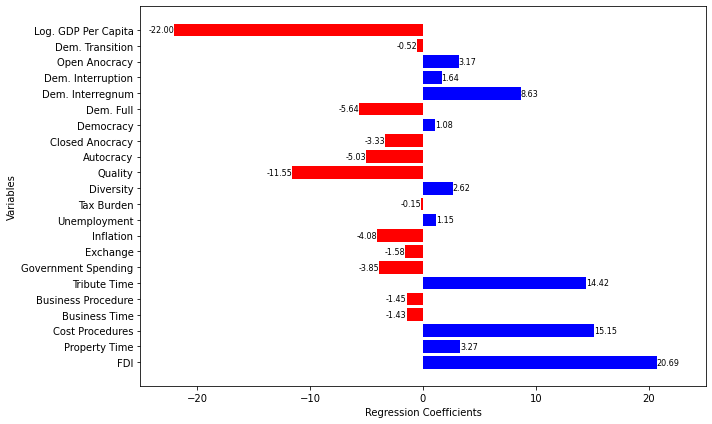

In [17]:
coeficientes = linear_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in coeficientes]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, coeficientes, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(coeficientes):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()
ax = plt.gca()
ax.set_xlim(-25, 25)
        
plt.show()

# Lasso

In [18]:
from sklearn.linear_model import Lasso

lasso_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'alpha': [1e-5, 1e-4, 1e-3, 0.01, 0.1, 1.0, 10.0, 100.0],  
    'max_iter': [1000, 2000, 3000, 5000]  
}

# Create a lasso model
lasso_model = Lasso(random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Perform Grid Search with cross-validation
lasso_grid_search = GridSearchCV(lasso_model, 
                                  lasso_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=kf,
                                  n_jobs=-1)

# Fitting the model
lasso_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", lasso_grid_search.best_params_)

# Get the best model
lasso_best_model = lasso_grid_search.best_estimator_

# Store fold scores for later calculations
all_fold_scores = []

# Print the mean and standard deviation of each fold in percentage
for i, (train_idx, test_idx) in enumerate(kf.split(X_train_scaled, y_train)):
    fold_scores = -lasso_grid_search.cv_results_['split{}_test_score'.format(i)]
    all_fold_scores.extend(fold_scores)  # Store fold scores for later calculations
    mean_fold_score = np.mean(fold_scores) * 100
    std_fold_score = np.std(fold_scores) * 100  

    print(f'Mean score for fold {i + 1}: {mean_fold_score:.2f}%, Standard Deviation: {std_fold_score:.2f}%')

# Calculate and print global mean and standard deviation
global_mean = np.mean(all_fold_scores) * 100
global_std = np.std(all_fold_scores) * 100
print(f'Global Mean: {global_mean:.2f}%, Global Standard Deviation: {global_std:.2f}%\n')

# Predictions and evaluations on test set
y_test_pred = lasso_grid_search.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'\nMean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')


Best Parameters:  {'alpha': 1e-05, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000}
Mean score for fold 1: 38.87%, Standard Deviation: 20.48%
Mean score for fold 2: 35.44%, Standard Deviation: 19.15%
Mean score for fold 3: 33.08%, Standard Deviation: 19.49%
Mean score for fold 4: 37.93%, Standard Deviation: 19.34%
Mean score for fold 5: 37.84%, Standard Deviation: 19.22%
Global Mean: 36.63%, Global Standard Deviation: 19.66%


Mean Absolute Percentage Error (MAPE) on test set: 27.77% 



Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.430e+03, tolerance: 1.832e+01


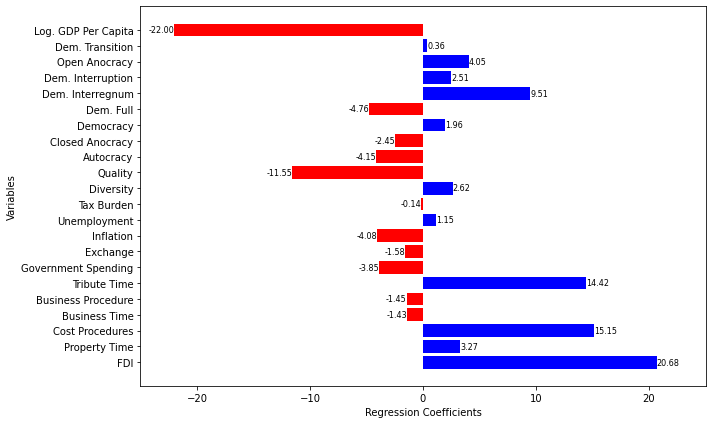

In [19]:
lasso_coeficients = lasso_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in lasso_coeficients]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, lasso_coeficients, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(lasso_coeficients):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()
ax = plt.gca()
ax.set_xlim(-25, 25)    

plt.show()

# Ridge

In [20]:
from sklearn.linear_model import Ridge

ridge_param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'alpha': [0.1, 0.5, 1.0, 1.5],  
    'max_iter': [1000, 2000, 3000]  
}

# Create a lasso model
ridge_model = Ridge(random_state=0)

kf = KFold(n_splits=5, shuffle=True, random_state=0)

# Perform Grid Search with cross-validation
ridge_grid_search = GridSearchCV(ridge_model, 
                                  ridge_param_grid, 
                                  scoring='neg_mean_absolute_percentage_error', 
                                  cv=kf,
                                  n_jobs=-1)

# Fitting the model
ridge_grid_search.fit(X_train_scaled, y_train)

# Print the best parameters
print("\nBest Parameters: ", ridge_grid_search.best_params_)

# Get the best model
ridge_best_model = ridge_grid_search.best_estimator_

# Store fold scores for later calculations
all_fold_scores = []

# Print the mean and standard deviation of each fold in percentage
for i, (train_idx, test_idx) in enumerate(kf.split(X_train_scaled, y_train)):
    fold_scores = -ridge_grid_search.cv_results_['split{}_test_score'.format(i)]
    all_fold_scores.extend(fold_scores)  # Store fold scores for later calculations
    mean_fold_score = np.mean(fold_scores) * 100
    std_fold_score = np.std(fold_scores) * 100  

    print(f'Mean score for fold {i + 1}: {mean_fold_score:.2f}%, Standard Deviation: {std_fold_score:.2f}%')

# Calculate and print global mean and standard deviation
global_mean = np.mean(all_fold_scores) * 100
global_std = np.std(all_fold_scores) * 100
print(f'Global Mean: {global_mean:.2f}%, Global Standard Deviation: {global_std:.2f}%\n')
# Predictions and evaluations on test set
y_test_pred = ridge_best_model.predict(X_test_scaled)
mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE) on test set: {mape_test:.2f}% \n')


Best Parameters:  {'alpha': 0.1, 'copy_X': True, 'fit_intercept': True, 'max_iter': 1000}
Mean score for fold 1: 25.91%, Standard Deviation: 0.55%
Mean score for fold 2: 24.89%, Standard Deviation: 0.88%
Mean score for fold 3: 22.76%, Standard Deviation: 0.09%
Mean score for fold 4: 26.40%, Standard Deviation: 0.12%
Mean score for fold 5: 26.64%, Standard Deviation: 0.51%
Global Mean: 25.32%, Global Standard Deviation: 1.51%

Mean Absolute Percentage Error (MAPE) on test set: 27.76% 



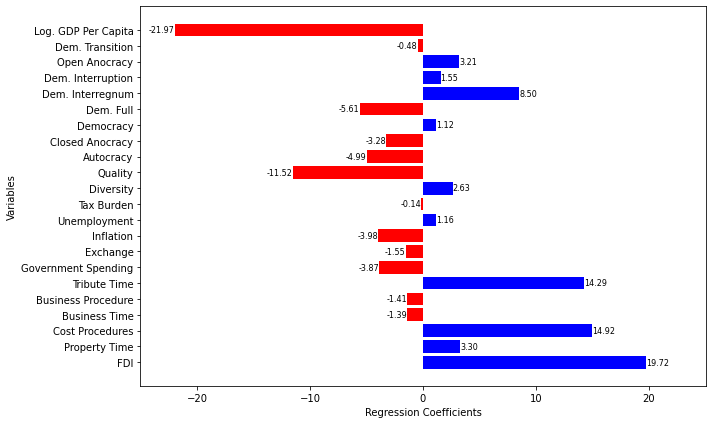

In [21]:
ridge_coeficients = ridge_best_model.coef_
colors = ['red' if coef < 0 else 'blue' for coef in ridge_coeficients]
plt.figure(figsize=(10, 6))


variables_names = X_train.columns.tolist()

plt.barh(variables_names, ridge_coeficients, color=colors)
plt.xlabel('Regression Coefficients')
plt.ylabel('Variables')


for i, coef in enumerate(ridge_coeficients):
    if coef < 0:
        plt.text(coef, i, f'{coef:.2f}', ha='right', va='center', color='black', fontsize=8)
    else:
        plt.text(coef, i, f'{coef:.2f}', ha='left', va='center', color='black', fontsize=8)
  
plt.tight_layout()
ax = plt.gca()
ax.set_xlim(-25, 25)     
        
plt.show()